# Import Library

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt
import pandas as pd
import numpy as np
import seaborn as sns

# Download Stock Data

In [13]:
#data = yf.download("TSLA", start="2023-01-01", end="2025-01-01")
#data.to_csv("TSLA.csv")

# Read Data and Data Processing

In [14]:
data = pd.read_csv("TSLA.csv", index_col=0, parse_dates=True)

# flatten column names if they are multi-index
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [c[0] for c in data.columns]
data.head()

/var/folders/zp/xkyq1t891mbf4mjnfh3f_9l80000gn/T/ipykernel_85658/212844731.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("TSLA.csv", index_col=0, parse_dates=True)


,Close,High,Low,Open,Volume
Price,,,,,
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,NaN,NaN,NaN,NaN,NaN
2023-01-03,108.0999984741211,118.80000305175781,104.63999938964844,118.47000122070312,231402800
2023-01-04,113.63999938964844,114.58999633789062,107.5199966430664,109.11000061035156,180389000
2023-01-05,110.33999633789062,111.75,107.16000366210938,110.51000213623047,157986300


In [15]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
data = data.dropna()

In [16]:
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

In [17]:
data

,Close,High,Low,Open,Volume
Price,,,,,
2023-01-03,108.099998,118.800003,104.639999,118.470001,231402800.0
2023-01-04,113.639999,114.589996,107.519997,109.110001,180389000.0
2023-01-05,110.339996,111.750000,107.160004,110.510002,157986300.0
2023-01-06,113.059998,114.389999,101.809998,103.000000,220911100.0
2023-01-09,119.769997,123.519997,117.110001,118.959999,190284000.0
...,...,...,...,...,...
2024-12-24,462.279999,462.779999,435.140015,435.899994,59551800.0
2024-12-26,454.130005,465.329987,451.019989,465.160004,76366400.0
2024-12-27,431.660004,450.000000,426.500000,449.519989,82666800.0


# Conver the data into bt format

In [18]:
data_bt = bt.feeds.PandasData(dataname=data)

# Create The Strategy

In [ ]:
class SMA_Strat(bt.Strategy):
    params = (('fast', 5), ('slow', 20),)

    def __init__(self):
        self.sma_fast = bt.ind.SMA(self.data.close, period=self.p.fast)
        self.sma_slow = bt.ind.SMA(self.data.close, period=self.p.slow)
        self.crossover = bt.ind.CrossOver(self.sma_fast, self.sma_slow)  # ✅ 更可靠
        self.port_val = {}

    def next(self):
        if len(self.data) < self.p.slow:
            return
        
        if not self.position: 
            if self.crossover > 0:  
                self.buy(exectype=bt.Order.Market)
        else:  
            if self.crossover < 0:  
                self.sell(exectype=bt.Order.Market)

        self.port_val[self.data.datetime.date(0)] = self.broker.getvalue()

    def stop(self):
        if self.position:
            self.close()

# Run the backtest engine

In [ ]:
param_combinations = [(f, s) for f in [5, 10, 15] for s in [20, 30, 50]]
results = []

for f, s in param_combinations:
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(100000)
    cerebro.addsizer(bt.sizers.FixedSize, stake = 10)

    cerebro.adddata(data_bt)

    cerebro.addstrategy(SMA_Strat, fast = f, slow = s)

    cerebro.addobserver(bt.observers.BuySell)

    cerebro.addobserver(bt.observers.Value)

    cerebro.broker.setcommission(commission=0.001)        
    cerebro.broker.set_coc(True)                 
    cerebro.broker.set_slippage_perc(perc=0.001)  

    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(
        bt.analyzers.SharpeRatio,
        _name='sharpe',
        timeframe=bt.TimeFrame.Days,
        annualize=True,
        factor=252,
        riskfreerate=0.0
    )

    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

    initial = cerebro.broker.getvalue()
    result = cerebro.run()
    end = cerebro.broker.getvalue()
    strat = result[0]


    df = pd.DataFrame(strat.port_val.items(), columns=['Date', 'PortfolioValue'])
    df.set_index('Date', inplace=True)
    df['DailyReturn'] = df['PortfolioValue'].pct_change()

    total_returns = strat.analyzers.returns.get_analysis()['rtot']

    sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio', 0)

    mean_return = df['DailyReturn'].mean() * 252  
    downside_returns = df.loc[df['DailyReturn'] < 0, 'DailyReturn']
    downside_std = downside_returns.std() * np.sqrt(252)
    
    if downside_std > 0:
        sortino = mean_return / downside_std
    else:
        sortino = 0

    volatility = df['DailyReturn'].std() * np.sqrt(252)
    
    trades = strat.analyzers.trades.get_analysis()

    closed_trades = trades.get('total', {}).get('closed', 0)
    won_trades = trades.get('won', {}).get('total', 0)

    if closed_trades > 0:
        winrate = won_trades / closed_trades
    else:
        winrate = 0

    results.append((f, s, initial, end, total_returns, sharpe, sortino, volatility, winrate))
    
df_results = pd.DataFrame(results, columns = ['Fast', 'Slow', 'Inital', 'End','Total Return', 'Sharpe', 'Sortino', 'Volatility', 'Winrate'])

best_row = df_results.loc[df_results['Sharpe'].idxmax()]
best_fast = int(best_row['Fast'])
best_slow = int(best_row['Slow'])

print(f"Best Strategy: Fast={best_fast}, Slow={best_slow}, Earn={end-initial}, Sharpe={best_row['Sharpe']:.3f}, Return={best_row['Total Return']:.3f}")

print(df_results)

Best Strategy: Fast=15, Slow=20, Earn=1503.7332502526842, Sharpe=0.961, Return=0.021
   Fast  Slow  Inital            End  Total Return    Sharpe   Sortino  \
0     5    20  100000  102033.604490      0.020132  0.945143  1.047333   
1     5    30  100000  101845.602616      0.018288  0.869415  0.920269   
2     5    50  100000  101106.913773      0.011008  0.524316  0.585577   
3    10    20  100000  102046.596389      0.020259  0.942715  1.004849   
4    10    30  100000  101916.543053      0.018984  0.893585  0.966403   
5    10    50  100000  100972.565473      0.009679  0.463899  0.514808   
6    15    20  100000  102081.490520      0.020601  0.960855  1.007409   
7    15    30  100000  101376.704299      0.013673  0.668414  0.684292   
8    15    50  100000  101503.733250      0.014925  0.681698  0.793666   

   Volatility   Winrate  
0    0.010997  0.384615  
1    0.010979  0.333333  
2    0.011246  0.285714  
3    0.011096  0.416667  
4    0.011087  0.333333  
5    0.011189  0.3

# Plot the Backtest Result

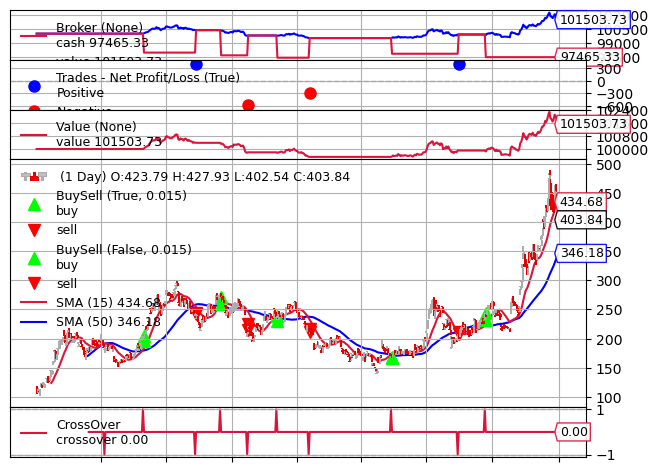

In [23]:
fig = cerebro.plot(style='candlestick', iplot=False, volume=False, figsize=(12,6))
plt.show()

# Portfolio Value Graph

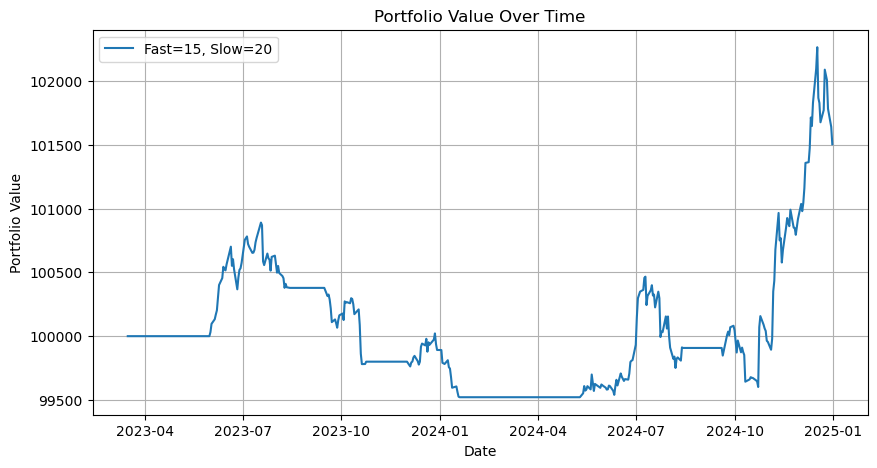

In [ ]:
portfolio_dfs = []

for f, s in param_combinations:
    ...
    result = cerebro.run()
    strat = result[0]

    df = pd.DataFrame(strat.port_val.items(), columns=['Date', 'PortfolioValue'])
    df.set_index('Date', inplace=True)
    df['DailyReturn'] = df['PortfolioValue'].pct_change()
    df['Fast'] = f
    df['Slow'] = s
    portfolio_dfs.append(df)

all_portfolio = pd.concat(portfolio_dfs)

best_df = all_portfolio[(all_portfolio['Fast'] == best_fast) & (all_portfolio['Slow'] == best_slow)]

plt.figure(figsize=(10,5))
plt.plot(best_df.index, best_df['PortfolioValue'], label=f'Fast={best_fast}, Slow={best_slow}')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# Result Data Plot

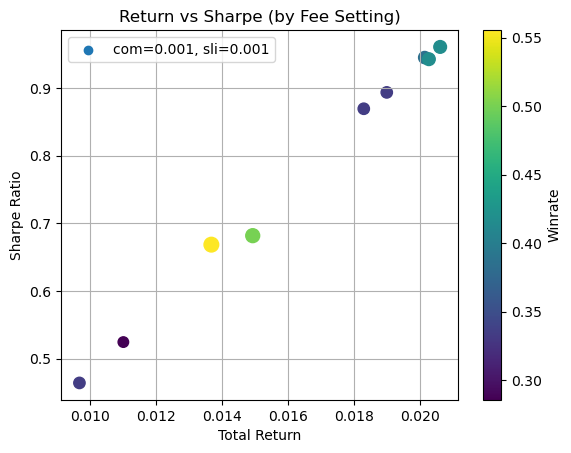

In [29]:
plt.scatter(df_results['Total Return'], df_results['Sharpe'], label=f'com={0.001}, sli={0.001}')
plt.scatter(df_results['Total Return'], df_results['Sharpe'], 
        c=df_results['Winrate'], cmap='viridis', s=df_results['Winrate']*200)
plt.colorbar(label='Winrate')

plt.xlabel('Total Return')
plt.ylabel('Sharpe Ratio')
plt.title('Return vs Sharpe (by Fee Setting)')
plt.legend()
plt.grid(True)
plt.show()

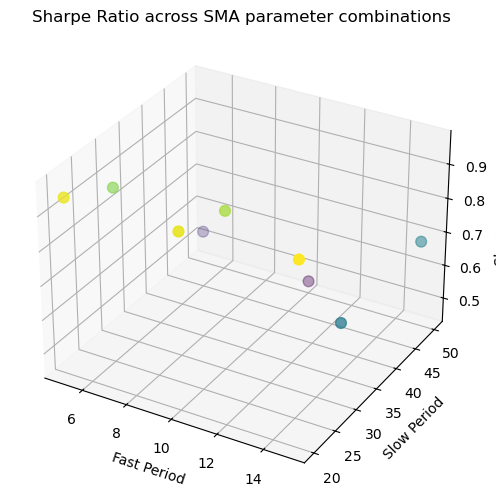

In [34]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_results['Fast'], df_results['Slow'], df_results['Sharpe'], c=df_results['Sharpe'], cmap='viridis', s=60)
ax.set_xlabel('Fast Period')
ax.set_ylabel('Slow Period')
ax.set_zlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio across SMA parameter combinations')
plt.show()